In [95]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal
import sqlite3
import json
import os
import re
from dotenv import load_dotenv

In [96]:
load_dotenv()

True

In [97]:
model = ChatGoogleGenerativeAI(
    model = 'gemini-2.5-flash',
    google_api_key = os.getenv('GEMINI_API_KEY')
)

In [98]:
class AgentState(TypedDict):
    user_query: str
    sql_query: str
    # validation_passed: bool
    validation_passed: Literal["passed", "failed"]
    feedback: str
    result: str
    iteration_count: int 


In [ ]:
def get_user_query(_: AgentState) -> AgentState:
    """Node to capture the user query (for clarity in the graph)."""
    user_query = input("Enter your question: ")
    return {
        "user_query": user_query,
        "sql_query": "",
        "validation_passed": "failed",
        "feedback": "",
        "result": "",
        "iteration_count": 0,
    }

In [99]:
def generate_sql(state: AgentState):
    with open("indian_deserts.json") as f:
        metadata = json.load(f)

    table = "indian_desserts"
    schema_info = metadata[table]
    
    schema_desc = []
    for col_name, col_info in schema_info["columns"].items():
        schema_desc.append(
            f"- {col_name} ({col_info['type']}): {col_info['description']}"
        )
    schema_text = "\n".join(schema_desc)

    prompt = f"""
    You are a SQL expert. Generate a valid SQLite query for the user's request.

    **Table:** {table}
    **Schema:**
    {schema_text}

    **User Query:** {state['user_query']}
    **Validator Feedback:** {state.get('feedback', 'None')}

    **CRITICAL INSTRUCTIONS:**
    - Return ONLY the raw SQL query with NO extra text, explanations, or prefixes
    - Do NOT include markdown code blocks, backticks, or the word "sql"
    - Do NOT end the query with a semicolon
    - Use proper SQLite syntax
    - **When asked about desserts, ALWAYS add: WHERE course = 'dessert'**
    - If feedback is provided, fix the issues mentioned

    Example: SELECT name, state FROM indian_desserts WHERE course = 'dessert' AND state = 'West Bengal'
    """

    response = model.invoke(prompt)
    
    # ROBUST CLEANING
    sql_query = response.content.strip() #Here I am removing the trailing and beginning white spaces using the .strip() method
    
    # Remove markdown code blocks which comes with gpts ``` ``` so that we are left with the main SQL code only
    sql_query = re.sub(r'^```sql\s*', '', sql_query, flags=re.IGNORECASE)
    sql_query = re.sub(r'^```\s*', '', sql_query)
    sql_query = re.sub(r'```$', '', sql_query)
    
    # Remove common prefixes
    # Sometimes the gpts prepend things like SQL or SQLite to the query. This is to remove that
    sql_query = re.sub(r'^\s*sql\s*', '', sql_query, flags=re.IGNORECASE)
    sql_query = re.sub(r'^\s*sqlite\s*', '', sql_query, flags=re.IGNORECASE)
    
    # Remove trailing semicolon
    sql_query = sql_query.rstrip('; \n\t')

    print(f"\n🧠 Generated SQL (Iteration {state['iteration_count']}): {sql_query}")
    
    return {
        **state, 
        "sql_query": sql_query,
        "iteration_count": state["iteration_count"] + 1
    }


In [100]:
def validate_sql(state: AgentState) -> AgentState:
    """
    Validate the SQL query by checking extracted column names against the schema.
    Provides concise feedback for the next iteration.
    """
    sql_query = state["sql_query"]
    validation_passed = True
    feedback = ""

    # Load valid column names from schema
    with open("indian_deserts.json") as f:
        metadata = json.load(f)
    valid_columns = set(metadata["indian_desserts"]["columns"].keys())

    # Ask model to extract column names
    prompt = f"""
    Extract ONLY the column names from this SQL query:
    ---
    {sql_query}
    ---
    Rules:
    - Include columns from SELECT and WHERE clauses.
    - Ignore SQL keywords, table names, and string literals (like 'West Bengal').
    - For SELECT *, return *.
    - Output comma-separated column names only.
    """

    try:
        response = model.invoke(prompt)
        extracted_cols_list = [
            c.strip().lower() for c in response.content.split(",") if c.strip()
        ]
        extracted_columns = set(extracted_cols_list)

        invalid_columns = extracted_columns - valid_columns

        if "*" in extracted_columns:
            feedback = "Query uses SELECT *, which is acceptable."
        elif invalid_columns:
            validation_passed = False
            feedback = (
                f"Invalid columns found: {', '.join(invalid_columns)}. "
                f"Valid columns are: {', '.join(valid_columns)}."
            )
        else:
            feedback = "All columns are valid."

    except Exception as e:
        validation_passed = False
        feedback = f"Validation error: {str(e)}"

    print(f"\n🧾 Validation Feedback: {feedback}")

    return {
        **state,
        "validation_passed": validation_passed,
        "feedback": feedback,
    }


In [101]:
# -----------------------------
# 4️⃣ Node 3 - Execute SQL
# -----------------------------
def execute_sql(state: AgentState):
    with open("indian_deserts.json") as f:
        metadata = json.load(f)

    db_path = "desserts.db"

    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    try:
        cursor.execute(state["sql_query"])
        rows = cursor.fetchall()
        result = rows if rows else "No results found."
        print("📊 Query Result:", result)
    except Exception as e:
        result = f"Execution Error: {e}"
        print(result)
    finally:
        conn.close()

    return {**state, "result": str(result)}


In [102]:
# Conditional edge for looping logic
def validation_check(state: AgentState):
    return "execute_sql" if state["validation_passed"] else "generate_sql"

In [103]:
# -----------------------------
# 5️⃣ Define Graph Structure (FIXED)
# -----------------------------
graph = StateGraph(AgentState)

# Add nodes
graph.add_node("generate_sql", generate_sql)
graph.add_node("validate_sql", validate_sql)
graph.add_node("execute_sql", execute_sql)

# Add edges
graph.add_edge(START, "generate_sql")
graph.add_edge("generate_sql", "validate_sql")

# FIXED: Add the path mapping dictionary
graph.add_conditional_edges(
    "validate_sql", 
    validation_check,
    {
        "execute_sql": "execute_sql",    # If validation passes
        "generate_sql": "generate_sql"   # If validation fails (loop back)
    }
)

graph.add_edge("execute_sql", END)

# Compile the graph
workflow = graph.compile()

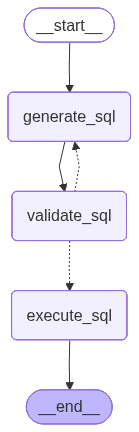

In [104]:
workflow

In [105]:
if __name__ == "__main__":
    print("🍰 Welcome to the Indian Desserts SQL Agent!")
    user_query = input("Enter your question: ")

    initial_state = {
        "user_query": user_query,
        "sql_query": "",
        "validation_passed": False,
        "feedback": "",
        "result": "",
        "iteration_count": 0 
    }

    result = workflow.invoke(initial_state)

    print("\n 👤 User Query: ", result["user_query"])
    print("\n 🎯 Final Query:", result["sql_query"])
    print("\n 📈 Final Result:", result["result"])

🍰 Welcome to the Indian Desserts SQL Agent!

🧠 Generated SQL (Iteration 0): SELECT name FROM indian_desserts WHERE course = 'dessert' AND state = 'West Bengal'

🧾 Validation Feedback: All columns are valid.
📊 Query Result: [('Balu shahi',), ('Gulab jamun',), ('Imarti',), ('Kalakand',), ('Cham cham',), ('Ledikeni',), ('Mihidana',), ('Misti doi',), ('Pantua',), ('Ras malai',), ('Rasgulla',), ('Sandesh',), ('Adhirasam',), ('Cheera Doi',), ('Goja',)]

 👤 User Query:  show all the dessert names of West bengal

 🎯 Final Query: SELECT name FROM indian_desserts WHERE course = 'dessert' AND state = 'West Bengal'

 📈 Final Result: [('Balu shahi',), ('Gulab jamun',), ('Imarti',), ('Kalakand',), ('Cham cham',), ('Ledikeni',), ('Mihidana',), ('Misti doi',), ('Pantua',), ('Ras malai',), ('Rasgulla',), ('Sandesh',), ('Adhirasam',), ('Cheera Doi',), ('Goja',)]
